In [ ]:
import numpy as np
from scipy.constants import e, m_e, hbar, electron_volt

import sys
sys.path.append("..")
import elecboltz

import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
# matplotlib settings
# reset defaults
mpl.rcdefaults()
# font
mpl.rcParams['font.size'] = 24
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['pdf.fonttype'] = 3
# plotting
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 20

In [3]:
def calculate_drude_3d(effective_mass, charge_density,
                       scattering_rate, magnetic_field):
    charge_mass = m_e * effective_mass
    omega_c = e * magnetic_field / charge_mass
    inverse_tensor = np.zeros((3, 3))
    np.fill_diagonal(inverse_tensor, scattering_rate)
    inverse_tensor[0, 1] = omega_c[2]
    inverse_tensor[1, 0] = -omega_c[2]
    inverse_tensor[0, 2] = -omega_c[1]
    inverse_tensor[2, 0] = omega_c[1]
    inverse_tensor[1, 2] = omega_c[0]
    inverse_tensor[2, 1] = -omega_c[0]
    return charge_density * e**2 / charge_mass * np.linalg.inv(inverse_tensor)

In [ ]:
def make_bandstructure(kf, three_dimensional=False, **kwargs):
    dispersion = "Ef * (kx^2 + ky^2"
    if three_dimensional:
        dispersion += " + kz^2"
    dispersion += ")"

    a = np.pi / kf * 1e10
    coeff = hbar**2 / (2*m_e)
    Ef = coeff * kf**2 / electron_volt * 1e3
    bandstructure = elecboltz.BandStructure(
        dispersion, Ef, [a, a, a], band_params={'Ef': Ef}, **kwargs)
    bandstructure.discretize()
    return bandstructure

In [5]:
kf = 1e10
bandstructure = make_bandstructure(1e10)

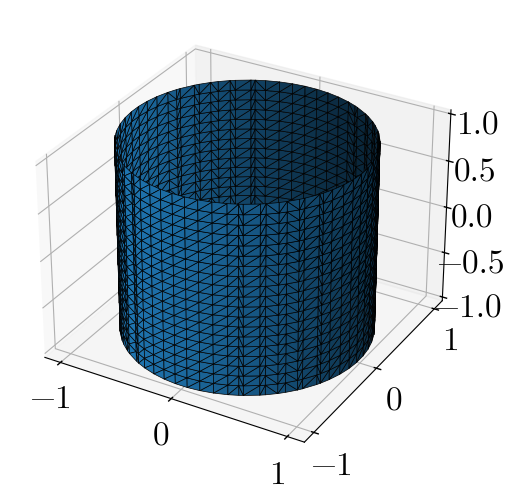

In [6]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_trisurf(
    bandstructure.kpoints[:, 0], bandstructure.kpoints[:, 1],
    bandstructure.kpoints[:, 2], triangles=bandstructure.kfaces,
    edgecolor='black', linewidth=0.5)
plt.show()

In [7]:
def loop_boltzmann_and_drude(conductivity, fields, scattering, charge_density):
    sigboltzxx = np.empty(len(fields))
    sigboltzxy = np.empty(len(fields))
    sigdrudexx = np.empty(len(fields))
    sigdrudexy = np.empty(len(fields))
    for i, field in enumerate(fields):
        conductivity.field = np.array([0, 0, field])
        conductivity.calculate()
        sigma_boltzmann = conductivity.sigma
        sigma_drude = calculate_drude_3d(
            1, charge_density, scattering * 1e12, conductivity.field)
        sigboltzxx[i] = sigma_boltzmann[0, 0]
        sigboltzxy[i] = sigma_boltzmann[0, 1]
        sigdrudexx[i] = sigma_drude[0, 0]
        sigdrudexy[i] = sigma_drude[0, 1]
    return sigboltzxx, sigboltzxy, sigdrudexx, sigdrudexy

In [8]:
charge_density = kf**3 / (2 * np.pi**2)
fields = np.linspace(0, 30, 100)
scattering = 1.0
conductivity = elecboltz.Conductivity(
    bandstructure, scattering_rate=scattering)
sigboltzxx, sigboltzxy, sigdrudexx, sigdrudexy = loop_boltzmann_and_drude(
    conductivity, fields, scattering, charge_density)

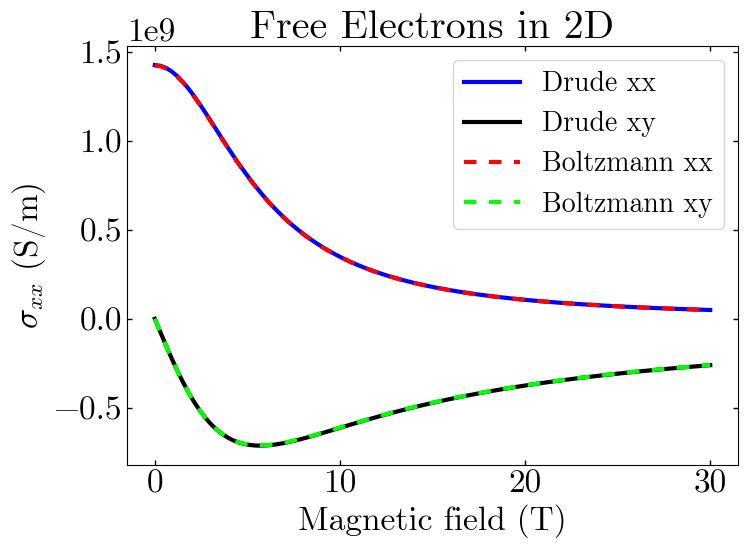

In [9]:
plt.plot(fields, sigdrudexx, label="Drude xx", color='blue')
plt.plot(fields, sigdrudexy, label="Drude xy", color='black')
plt.plot(fields, sigboltzxx, label="Boltzmann xx",
            color='red', linestyle=(0, (3, 3)))
plt.plot(fields, sigboltzxy, label="Boltzmann xy",
            color='lime', linestyle=(0, (3, 3)))
plt.xlabel("Magnetic field (T)")
plt.ylabel(r"$\sigma_{xx}$ (S/m)")
plt.title("Free Electrons in 2D")
plt.legend()
plt.tight_layout()
plt.savefig("test_vs_drude_2d.pdf", bbox_inches='tight')
plt.show()

In [12]:
kf = 1e10
scattering = 1.0
fields = np.linspace(0, 30, 100)
charge_density = kf**3 / (2 * np.pi**2)

resolutions = np.arange(10, 42, 2)
errors = np.empty_like(resolutions, dtype=float)
for i, resolution in enumerate(resolutions):
    bandstructure = make_bandstructure(kf, resolution=resolution)
    conductivity = elecboltz.Conductivity(
        bandstructure, scattering_rate=scattering)
    sigboltzxx, sigboltzxy, sigdrudexx, sigdrudexy = loop_boltzmann_and_drude(
        conductivity, fields, scattering, charge_density)
    nonzeroxy = np.nonzero(sigdrudexy)
    errors[i] = max(
        np.max(np.abs(sigboltzxx-sigdrudexx) / sigdrudexx),
        np.max(np.abs(sigboltzxy-sigdrudexy)[nonzeroxy]
               / sigdrudexy[nonzeroxy]))

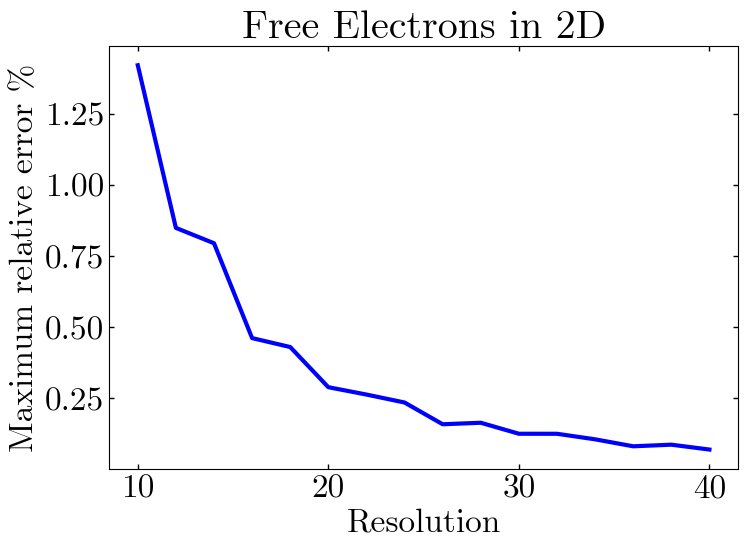

In [14]:
plt.plot(resolutions, 100 * errors, color='blue')
plt.xlabel("Resolution")
plt.ylabel("Maximum relative error %")
plt.title("Free Electrons in 2D")
plt.tight_layout()
plt.savefig("test_vs_drude_2d_error.pdf", bbox_inches='tight')
plt.show()